# Bayesian Inference for Coin Flip Experiments

## Introduction

Bayesian inference provides a principled framework for updating our beliefs about unknown parameters as we observe data. In this notebook, we explore the canonical example of Bayesian statistics: inferring the bias of a coin from observed flips.

## Theoretical Foundation

### The Problem

Consider a coin with unknown probability $\theta$ of landing heads. We flip the coin $n$ times and observe $k$ heads. Our goal is to infer the posterior distribution of $\theta$ given this data.

### Bayes' Theorem

Bayes' theorem relates the posterior probability to the prior and likelihood:

$$P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)}$$

where:
- $P(\theta | D)$ is the **posterior**: our updated belief about $\theta$ after observing data $D$
- $P(D | \theta)$ is the **likelihood**: the probability of observing data $D$ given $\theta$
- $P(\theta)$ is the **prior**: our initial belief about $\theta$
- $P(D)$ is the **evidence**: a normalizing constant

### Likelihood Function

For $n$ coin flips with $k$ heads, the likelihood follows a binomial distribution:

$$P(D | \theta) = \binom{n}{k} \theta^k (1-\theta)^{n-k}$$

### Prior Distribution

We use a Beta distribution as our prior, which is conjugate to the binomial likelihood:

$$P(\theta) = \text{Beta}(\theta | \alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}$$

where $B(\alpha, \beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$ is the Beta function.

### Posterior Distribution

Due to conjugacy, the posterior is also a Beta distribution:

$$P(\theta | D) = \text{Beta}(\theta | \alpha + k, \beta + n - k)$$

This elegant result shows that we simply update the Beta parameters by adding the number of successes to $\alpha$ and the number of failures to $\beta$.

### Posterior Statistics

The posterior mean and variance are:

$$\mathbb{E}[\theta | D] = \frac{\alpha + k}{\alpha + \beta + n}$$

$$\text{Var}[\theta | D] = \frac{(\alpha + k)(\beta + n - k)}{(\alpha + \beta + n)^2(\alpha + \beta + n + 1)}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Configure plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

## Implementation

### Define Bayesian Update Function

In [2]:
def bayesian_update(prior_alpha, prior_beta, n_heads, n_tails):
    """
    Perform Bayesian update for coin flip experiment.
    
    Parameters
    ----------
    prior_alpha : float
        Alpha parameter of Beta prior
    prior_beta : float
        Beta parameter of Beta prior
    n_heads : int
        Number of observed heads
    n_tails : int
        Number of observed tails
    
    Returns
    -------
    posterior_alpha : float
        Alpha parameter of Beta posterior
    posterior_beta : float
        Beta parameter of Beta posterior
    """
    posterior_alpha = prior_alpha + n_heads
    posterior_beta = prior_beta + n_tails
    return posterior_alpha, posterior_beta


def compute_posterior_stats(alpha, beta):
    """
    Compute mean, variance, and credible interval for Beta distribution.
    
    Parameters
    ----------
    alpha : float
        Alpha parameter of Beta distribution
    beta : float
        Beta parameter of Beta distribution
    
    Returns
    -------
    dict
        Dictionary containing mean, variance, and 95% credible interval
    """
    dist = stats.beta(alpha, beta)
    return {
        'mean': dist.mean(),
        'variance': dist.var(),
        'std': dist.std(),
        'ci_95': dist.ppf([0.025, 0.975])
    }

### Generate Simulated Data

We simulate coin flips from a coin with true bias $\theta_{\text{true}} = 0.7$.

In [3]:
# True probability of heads (unknown to the inference procedure)
theta_true = 0.7

# Total number of flips
n_flips = 100

# Simulate coin flips
flips = np.random.binomial(1, theta_true, n_flips)
cumulative_heads = np.cumsum(flips)
cumulative_tails = np.arange(1, n_flips + 1) - cumulative_heads

print(f"True bias: θ = {theta_true}")
print(f"Total flips: {n_flips}")
print(f"Observed heads: {cumulative_heads[-1]}")
print(f"Observed tails: {cumulative_tails[-1]}")
print(f"Observed proportion: {cumulative_heads[-1]/n_flips:.3f}")

True bias: θ = 0.7
Total flips: 100
Observed heads: 70
Observed tails: 30
Observed proportion: 0.700


### Sequential Bayesian Updates

We now perform sequential Bayesian updates, starting from different priors, to visualize how the posterior evolves as we observe more data.

In [4]:
# Define different priors to compare
priors = {
    'Uniform (α=1, β=1)': (1, 1),
    'Skeptical of bias (α=5, β=5)': (5, 5),
    'Strong prior at 0.5 (α=20, β=20)': (20, 20),
    'Prior favoring heads (α=3, β=1)': (3, 1)
}

# Points at which to evaluate posterior
theta_range = np.linspace(0, 1, 1000)

# Observation points for visualization
observation_points = [0, 1, 5, 10, 25, 50, 100]

### Visualization of Posterior Evolution

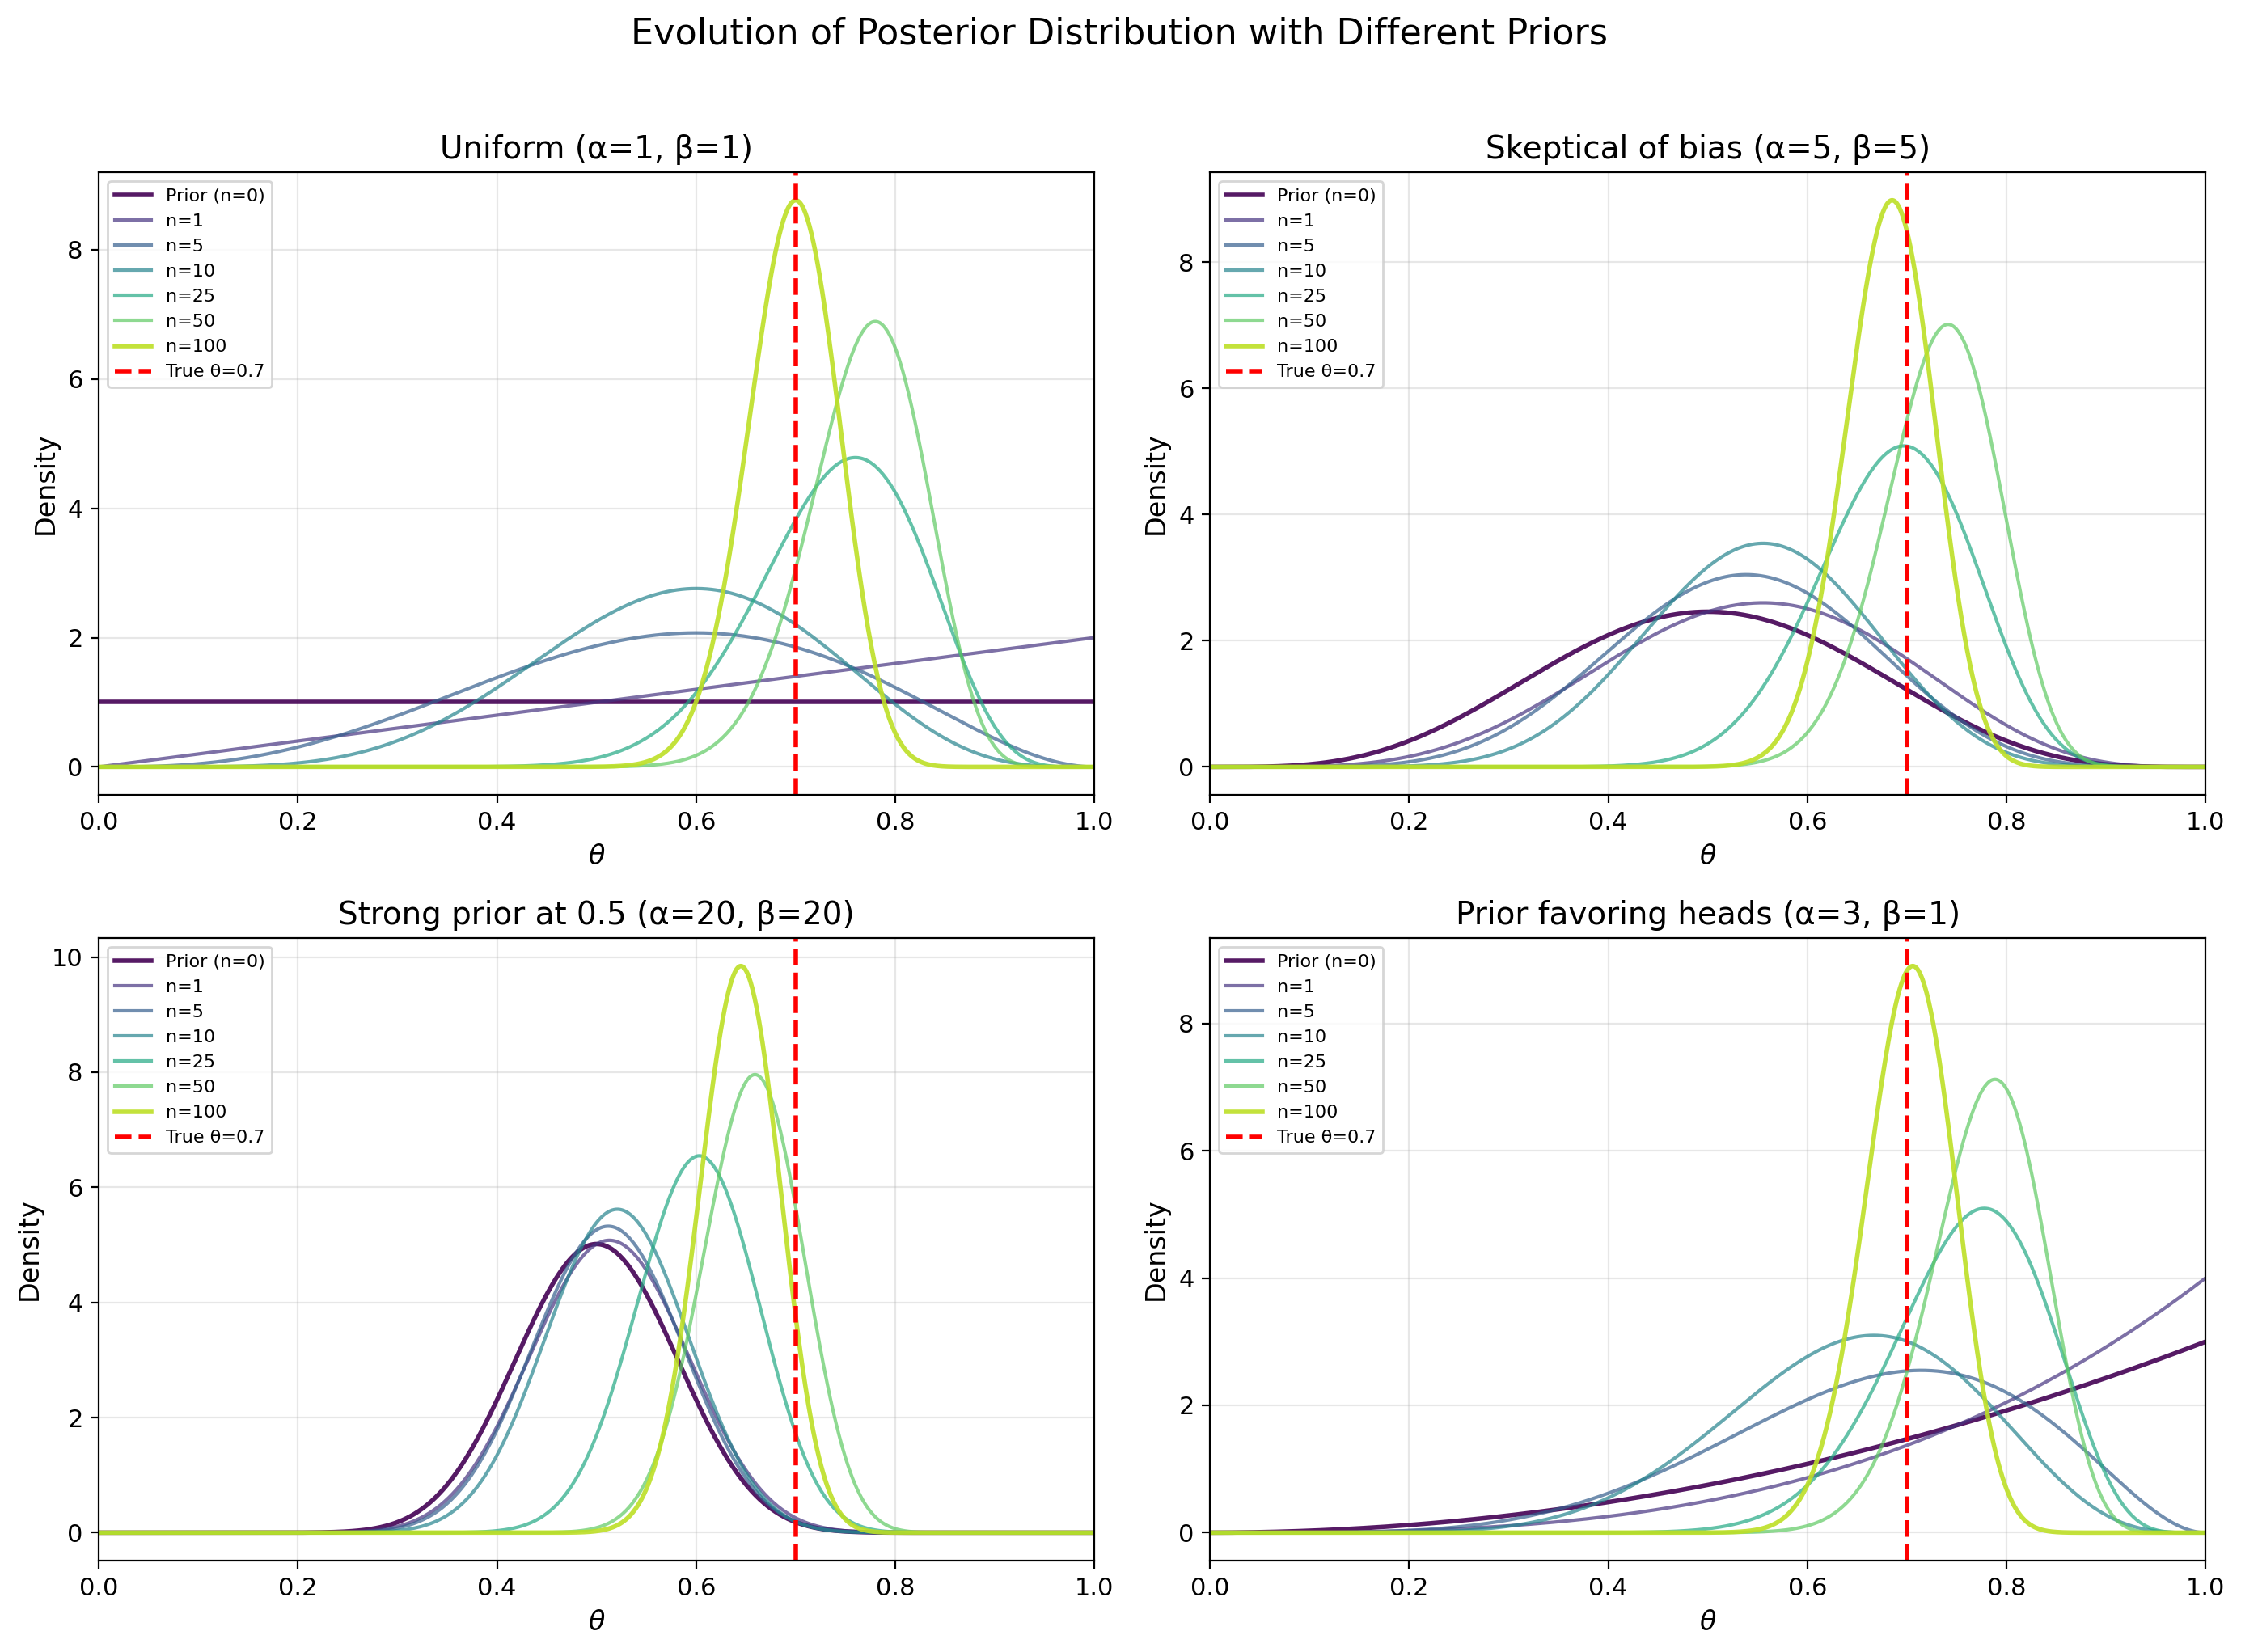


Plot saved to 'plot.png'


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0, 0.9, len(observation_points)))

for idx, (prior_name, (alpha_0, beta_0)) in enumerate(priors.items()):
    ax = axes[idx]
    
    for i, n_obs in enumerate(observation_points):
        if n_obs == 0:
            alpha_n, beta_n = alpha_0, beta_0
            label = f'Prior (n=0)'
        else:
            n_heads = cumulative_heads[n_obs - 1]
            n_tails = cumulative_tails[n_obs - 1]
            alpha_n, beta_n = bayesian_update(alpha_0, beta_0, n_heads, n_tails)
            label = f'n={n_obs}'
        
        posterior = stats.beta(alpha_n, beta_n)
        pdf = posterior.pdf(theta_range)
        
        ax.plot(theta_range, pdf, color=colors[i], 
                linewidth=2 if n_obs in [0, 100] else 1.5,
                alpha=0.9 if n_obs in [0, 100] else 0.7,
                label=label)
    
    ax.axvline(theta_true, color='red', linestyle='--', linewidth=2, 
               label=f'True θ={theta_true}')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel('Density')
    ax.set_title(prior_name)
    ax.legend(loc='upper left', fontsize=8)
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3)

plt.suptitle('Evolution of Posterior Distribution with Different Priors', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('bayesian_inference_coin_flip_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

### Quantitative Analysis of Final Posteriors

In [6]:
print("Final Posterior Statistics after 100 observations")
print("=" * 70)

total_heads = cumulative_heads[-1]
total_tails = cumulative_tails[-1]

for prior_name, (alpha_0, beta_0) in priors.items():
    alpha_n, beta_n = bayesian_update(alpha_0, beta_0, total_heads, total_tails)
    stats_dict = compute_posterior_stats(alpha_n, beta_n)
    
    print(f"\n{prior_name}")
    print(f"  Posterior parameters: α={alpha_n}, β={beta_n}")
    print(f"  Posterior mean: {stats_dict['mean']:.4f}")
    print(f"  Posterior std: {stats_dict['std']:.4f}")
    print(f"  95% Credible Interval: [{stats_dict['ci_95'][0]:.4f}, {stats_dict['ci_95'][1]:.4f}]")
    print(f"  Contains true θ={theta_true}: {stats_dict['ci_95'][0] <= theta_true <= stats_dict['ci_95'][1]}")

Final Posterior Statistics after 100 observations

Uniform (α=1, β=1)
  Posterior parameters: α=71, β=31
  Posterior mean: 0.6961
  Posterior std: 0.0453
  95% Credible Interval: [0.6039, 0.7810]
  Contains true θ=0.7: True

Skeptical of bias (α=5, β=5)
  Posterior parameters: α=75, β=35
  Posterior mean: 0.6818
  Posterior std: 0.0442
  95% Credible Interval: [0.5922, 0.7651]
  Contains true θ=0.7: True

Strong prior at 0.5 (α=20, β=20)
  Posterior parameters: α=90, β=50
  Posterior mean: 0.6429
  Posterior std: 0.0404
  95% Credible Interval: [0.5620, 0.7199]
  Contains true θ=0.7: True

Prior favoring heads (α=3, β=1)
  Posterior parameters: α=73, β=31
  Posterior mean: 0.7019
  Posterior std: 0.0446
  95% Credible Interval: [0.6110, 0.7855]
  Contains true θ=0.7: True


### Prior Sensitivity Analysis

Let's examine how the posterior mean converges to the true value as we collect more data, demonstrating that with sufficient data, the influence of the prior diminishes.

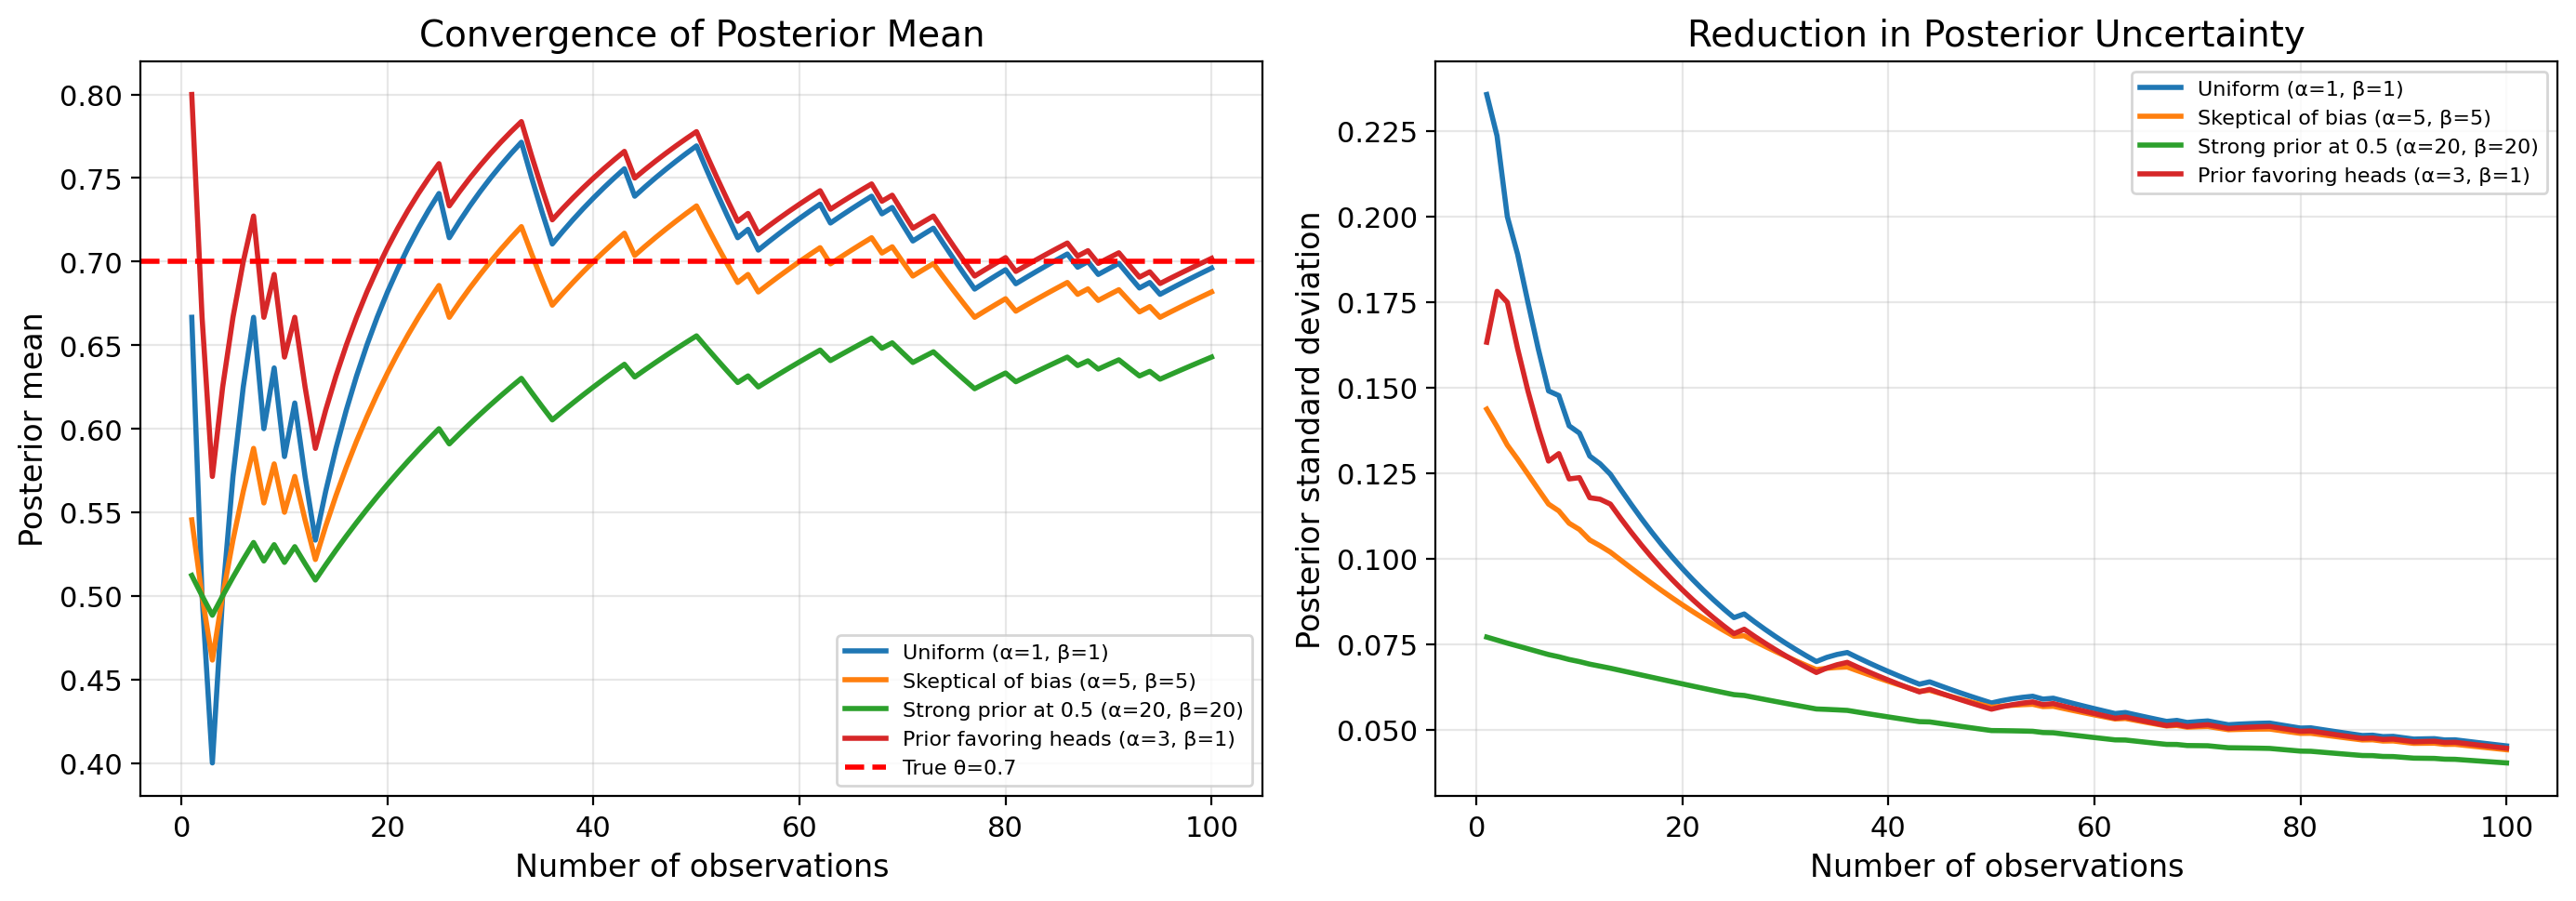

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Posterior mean evolution
n_observations = np.arange(1, n_flips + 1)

for prior_name, (alpha_0, beta_0) in priors.items():
    posterior_means = []
    for n in n_observations:
        alpha_n = alpha_0 + cumulative_heads[n-1]
        beta_n = beta_0 + cumulative_tails[n-1]
        posterior_means.append(alpha_n / (alpha_n + beta_n))
    
    ax1.plot(n_observations, posterior_means, linewidth=2, label=prior_name)

ax1.axhline(theta_true, color='red', linestyle='--', linewidth=2, label=f'True θ={theta_true}')
ax1.set_xlabel('Number of observations')
ax1.set_ylabel('Posterior mean')
ax1.set_title('Convergence of Posterior Mean')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Plot 2: Posterior standard deviation evolution
for prior_name, (alpha_0, beta_0) in priors.items():
    posterior_stds = []
    for n in n_observations:
        alpha_n = alpha_0 + cumulative_heads[n-1]
        beta_n = beta_0 + cumulative_tails[n-1]
        var = (alpha_n * beta_n) / ((alpha_n + beta_n)**2 * (alpha_n + beta_n + 1))
        posterior_stds.append(np.sqrt(var))
    
    ax2.plot(n_observations, posterior_stds, linewidth=2, label=prior_name)

ax2.set_xlabel('Number of observations')
ax2.set_ylabel('Posterior standard deviation')
ax2.set_title('Reduction in Posterior Uncertainty')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated Bayesian inference for estimating the bias of a coin:

1. **Conjugate Prior**: The Beta-Binomial conjugacy provides closed-form posterior updates
2. **Prior Influence**: Different priors lead to different posteriors with limited data, but converge as data accumulates
3. **Uncertainty Quantification**: The posterior provides not just point estimates but full uncertainty quantification via credible intervals
4. **Sequential Learning**: Bayesian inference naturally accommodates sequential data through iterative updates

The key insight is that Bayesian inference provides a principled way to combine prior knowledge with observed data, with the data eventually overwhelming the prior as more observations are collected.